
# Notebook for training and testing YOLTv4

#### _Author: Adam Van Etten - February 2021_

This notebook is assumed to be running in the yoltv4 conda environment.   Below, we provide examples of how to use this repository with the open-source [Rareplanes](https://registry.opendata.aws/rareplanes/) dataset. 


In [31]:
from shapely.affinity import translate
from shapely.geometry import box
import matplotlib.pyplot as plt
from shapely.wkt import loads
from imp import reload
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import numpy as np
import collections
import skimage.io
import shapely
import random
import shutil
import imp
import cv2
import sys
import os

yoltv4_path = '/local_data/cosmiq/src/yoltv4/'
sys.path.append(os.path.join(yoltv4_path, 'yoltv4'))
import prep_train
import tile_ims_labels
import post_process
reload(prep_train)

# set dataset path
data_root = '/local_data/cosmiq/wdata/rareplanes'

------
## 1. Training Preparation

------
We assume that images are large .tif files, with one label for each image.  Labels can be .geojsons, or a .csv.  Either way, the labels are assumed to be in pixel coordinates (see [solaris](https://github.com/CosmiQ/solaris) for tools to convert geographic coordinates to pixel coordinates.  Further labels are assumed to have a minimum of the following columns:

    'geometry', 'category', image_name'
    
We want the labels in the form of a geodataframe, which can be loaded via:
    
    gdf_pix = gpd.read_file(path_to_labels)

_________
### 1A. Extract the cutouts from the image, centered on the aircraft, modulo some jitter 

In [ ]:
# get cutouts for all images in the training corpus

df_polys = gdf_pix.copy()
yolt_image_ext='.jpg'
pop = 'train'

outdir_root = os.path.join(data_root,  pop, 'yoltv4')
im_dir = os.path.join(data_root, pop, 'images')
im_list = [z for z in os.listdir(im_dir) if z.endswith('.tif')]
verbose = True
super_verbose = False

# outputs
outdir_ims = os.path.join(outdir_root, 'images')
outdir_labels = os.path.join(outdir_root, 'labels')
outdir_yolt_plots = os.path.join(outdir_root, 'yolt_plot_bboxes')
print("outdir_ims:", outdir_ims)
# make dirs
for z in (outdir_ims, outdir_labels, outdir_yolt_plots):
    os.makedirs(z)

# extract cutouts and labels
for i,im_name in enumerate(im_list):
    im_path = os.path.join(im_dir, im_name)
    print(i, "/", len(im_list), im_name)
    prep_train.yolt_from_df(im_path, df_polys, 
                        window_size=416, 
                        jitter_frac=0.2,
                        min_obj_frac=0.6,
                        max_obj_count=100000,
                        geometry_col='geometry', 
                        category_col='category',
                        image_fname_col='image_name',
                        outdir_ims=outdir_ims, 
                        outdir_labels=outdir_labels,
                        outdir_yolt_plots=outdir_yolt_plots,
                        max_plots=5,
                        yolt_image_ext=yolt_image_ext,
                        verbose=verbose, super_verbose=super_verbose)

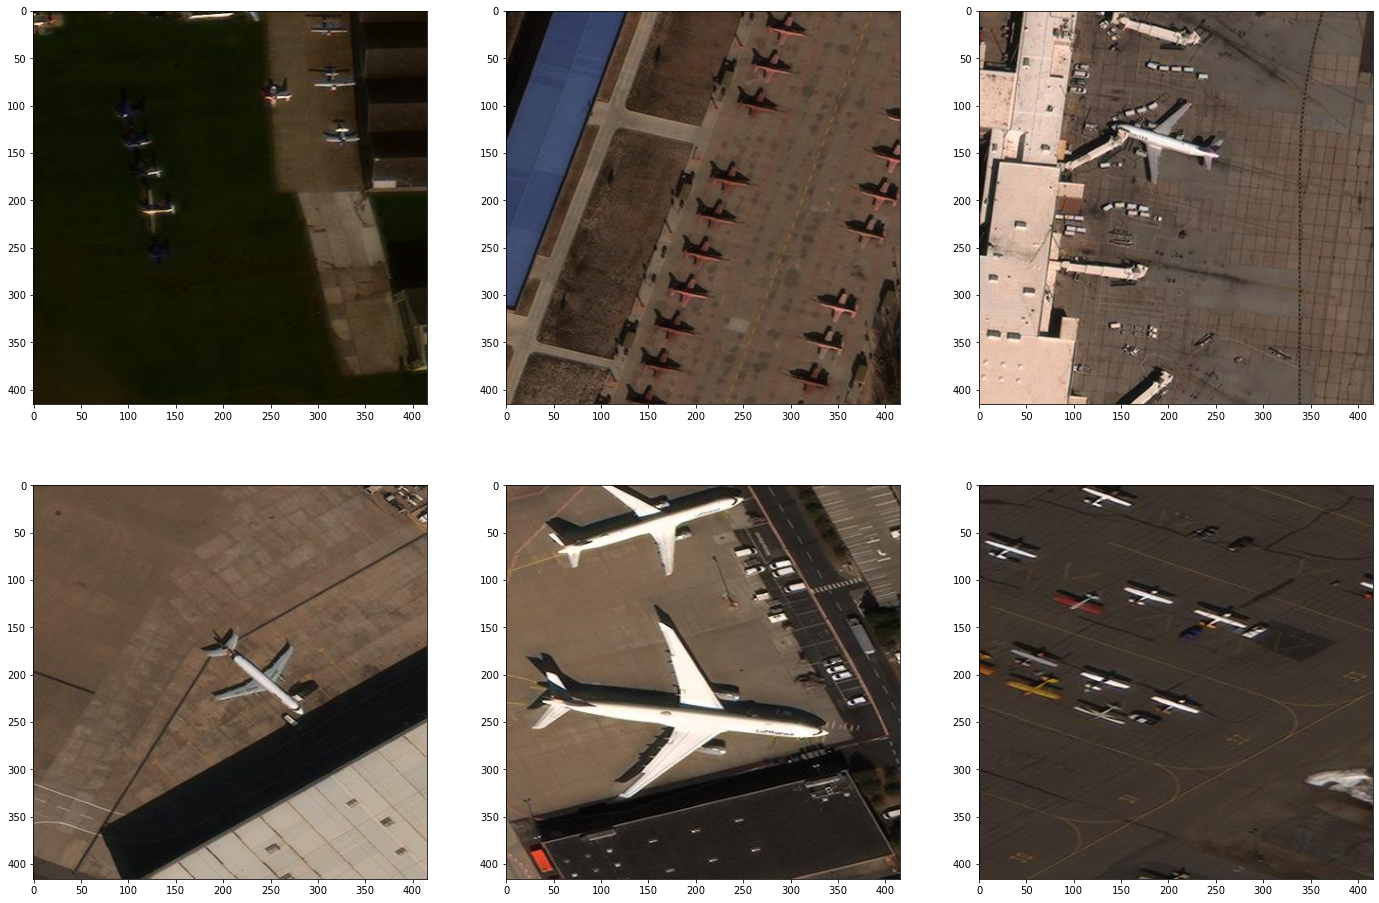

In [22]:
# visualize some of the outputs cutouts
dir_tmp = outdir_ims
rows, cols = 2, 3
figsize = 8
paths_tmp = [os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp) if j.endswith('.jpg')]
rand_selection = random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

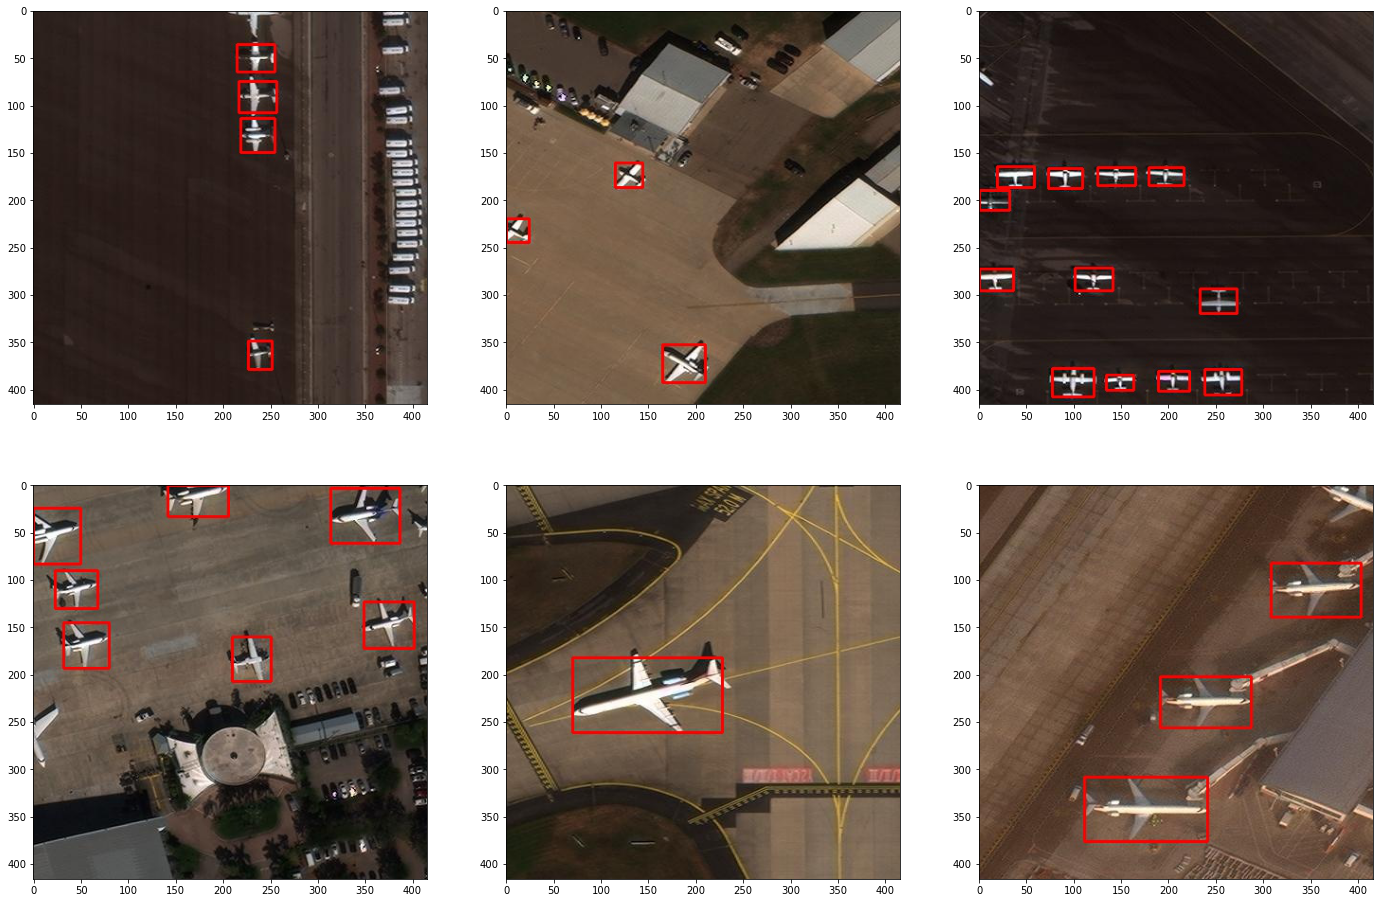

In [29]:
# visualize some of the yolt labels
dir_tmp = outdir_yolt_plots
rows, cols = 2, 3
figsize = 8
paths_tmp = [os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp) if j.endswith('.jpg')]
rand_selection = random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

### 1B. Create text files for training

YOLTv4 requires four text files for training purposes, which we detail below.

In [32]:
# set  paths
pop = 'train'
n_classes = 30
outdir_root = os.path.join(data_root,  pop, 'yoltv4')
txt_dir = os.path.join(outdir_root, 'txt')
os.makedirs(txt_dir) 

names_path = os.path.join(txt_dir, 'rareplanes.name')
train_list_path = os.path.join(txt_dir, 'rareplanes_train_images_list.txt')
valid_list_path = os.path.join(txt_dir, 'rareplanes_valid_images_list.txt')
dot_data_path = os.path.join(txt_dir, 'rareplanes_train.data')

print("names_path:", names_path)
print("train_list_path:", train_list_path)
print("valid_list_path:", valid_list_path)
print("dot_data_path:", dot_data_path)

names_path: /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes.name
train_list_path: /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes_train_images_list.txt
valid_list_path: /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes_valid_images_list.txt
dot_data_path: /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes_train.data


#### .names file:
    
    YOLTv4 requires a .names file with the name of each object.  For example, if we have 30 classes, the rareplanes.name file looks like:
    
        aircraft_type0
        aircraft_type1
        aircraft_type2
        ...
        aircraft_type29 

#### \_list.txt files

    YOLTv4 also requires a txt file listing the training and validation images, which we create below.

In [ ]:
valid_iter = 5   # means every 5th item is in valid set

# yolt outputs
outdir_ims = os.path.join(outdir_root, 'images')
outdir_labels = os.path.join(outdir_root, 'labels')

im_list_tot = sorted([os.path.join(outdir_ims, z) for z in os.listdir(outdir_ims) if z.endswith('.jpg')])
# make train and valid_list
im_list_train, im_list_valid = [], []
for i, im_path in enumerate(im_list_tot):
    if (i % valid_iter) == 0:
        im_list_valid.append(im_path)
    else:
        im_list_train.append(im_path)
# print("len im_list_train:", len(im_list_train))
# print("len im_list_valid:", len(im_list_valid))

# create txt files of image paths
for list_tmp, outpath_tmp in [[im_list_train, train_list_path], [im_list_valid, valid_list_path]]:
    df_tmp = pd.DataFrame({'image': list_tmp})
    df_tmp.to_csv(outpath_tmp, header=False, index=False)

# print("outpath_tmp:", outpath_tmp)
# !head {outpath_tmp}

#### .data file

    Create rareplanes.data, according to the command below:

In [35]:
!echo 'classes = ' {n_classes} > {dot_data_path}
!echo 'train = ' {train_list_path} >> {dot_data_path}
!echo 'valid = ' {valid_list_path} >> {dot_data_path}
!echo 'names = ' {names_path} >> {dot_data_path}
!echo 'backup = backup/' >> {dot_data_path}
!cat {dot_data_path}

classes =  30
train =  /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes_train_images_list.txt
valid =  /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes_valid_images_list.txt
names =  /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes.name
backup = backup/


### 1C. Copy labels to training image directory

For YOLTv4, images need to be in the same folder as images for training

In [ ]:
pop = 'train'
outdir_root = os.path.join(data_root,  pop, 'yoltv4')
outdir_ims = os.path.join(outdir_root, 'images')
outdir_labels = os.path.join(outdir_root, 'labels')

# copy
for f in os.listdir(outdir_labels):
    if f.endswith('.txt'):
        shutil.copy(os.path.join(outdir_labels, f), outdir_ims)

### 1D. Set up the .cfg file

The data is now prepped, so set up the .cfg file in the _/yoltv4/darknet/cfg_ directory according to your data.  The _yoltv4\_rareplanes.cfg_ file has already been formatted, but for custom data, see instructions [here](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects)):

* Change line max_batches to (classes*2000 but not less than number of training images, but not less than number of training images and not less than 6000), for example max_batches=6000 if you train for 3 classes

* Change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
    
* Set network size width=416 height=416 or any value multiple of 32

* Change line classes=80 to your number of objects in each of 3 [yolo]-layers:

* Change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers. So if classes=1 then should be filters=18. If classes=2 then write filters=21.




___
## 2. Train

With data and cfgs fully prepped, we simply run the following comand on the command line in the yoltv4_gpu0 docker container (see README.md for creating this docker container).

    cd /yoltv4/darknet
	time ./darknet detector train \
        /local_data/cosmiq/wdata/rareplanes/train/yoltv4/txt/rareplanes_train.data \
        cfg/yoltv4_rareplanes.cfg \
        weights/yolov4.conv.137 \
        -dont_show -mjpeg_port 8090 -map


Review progress (plotted at: _/yoltv4/darknet/chart\_yoltv4\_rareplanes.png_), as below:

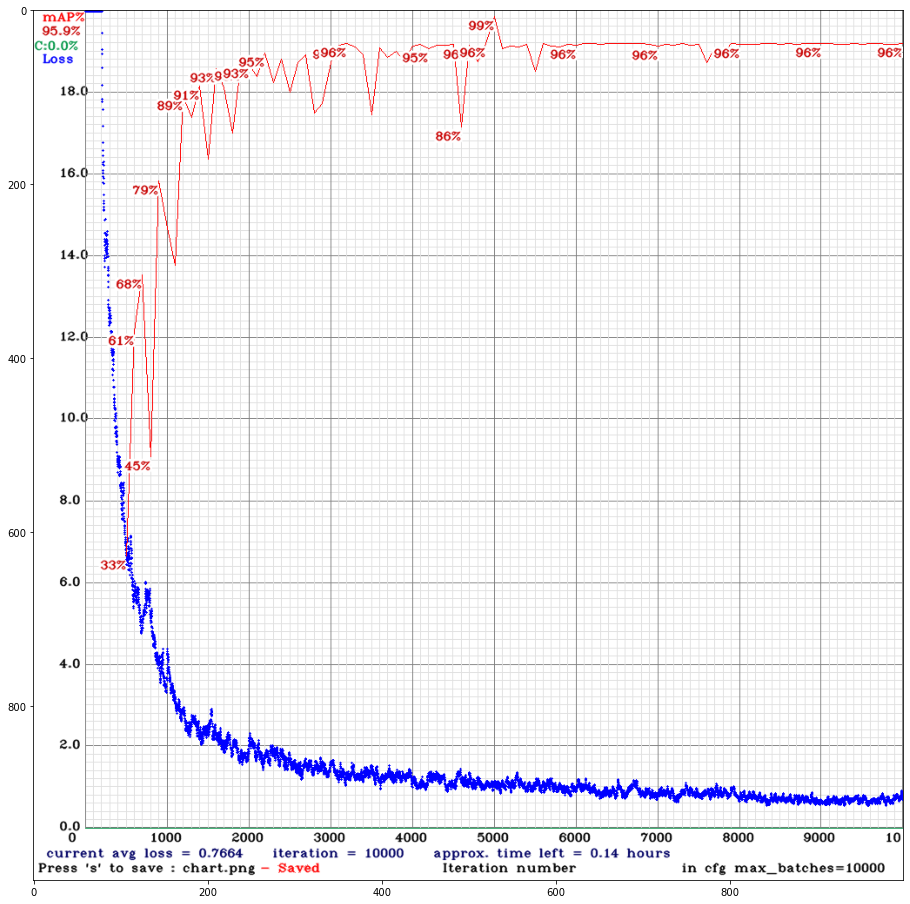

In [36]:
# view progress
chart_path = '/yoltv4/darknet/chart_yoltv4_rareplanes.png'
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(skimage.io.imread(chart_path))

-----
## 3. Prepare Test Data

Follow a similar approach as detailed above for training.

In [ ]:
pop = 'test'
data_root_tmp = os.path.join(data_root, pop)
outdir_root = os.path.join(data_root_tmp, 'yoltv4')
outdir_ims = os.path.join(outdir_root, 'images_slice')
outdir_txt = os.path.join(outdir_root, 'txt')
outpath_test_txt = os.path.join(outdir_txt, 'test.txt')
names_path = os.path.join(outdir_txt, 'rareplanes.name')
# valid_list_path = os.path.join(txt_dir, 'rareplanes_test_images_list.txt')
dot_data_path = os.path.join(outdir_txt, 'rareplanes_test.data')
os.makedirs(outdir_ims, exist_ok=True)
os.makedirs(outdir_txt, exist_ok=True)

sliceHeight, sliceWidth = 416, 416
slice_overlap=0.2
slice_sep = '__'
out_ext = '.jpg'
overwrite = False
verbose = False

im_dir = os.path.join(data_root_tmp, 'images')
im_list = [z for z in os.listdir(im_dir) if z.endswith('.tif')]

#################
# slice images
for i,im_name in enumerate(im_list):
    im_path = os.path.join(im_dir, im_name)
    im_tmp = skimage.io.imread(im_path)
    h, w = im_tmp.shape[:2]
    if verbose:
        print(i, "/", len(im_list), im_name, "h, w =", h, w)

    # tile data
    out_name = im_name.split('.')[0]
    tile_ims_labels.slice_im_plus_boxes(
        im_path, out_name, outdir_ims,
        sliceHeight=sliceHeight, sliceWidth=sliceWidth,
        overlap=slice_overlap, slice_sep=slice_sep,
        skip_highly_overlapped_tiles=False,
        overwrite=overwrite,
        out_ext=out_ext, verbose=verbose)

#################
# make list of test files
im_list_test = []
for f in sorted([z for z in os.listdir(outdir_ims) if z.endswith('.jpg')]):
    im_list_test.append(os.path.join(outdir_ims, f))
df_tmp = pd.DataFrame({'image': im_list_test})
df_tmp.to_csv(outpath_test_txt, header=False, index=False)
# print("N test ims:", len(df_tmp))
# !head {outpath_test_txt}

#################
# create .data file
!echo 'classes = ' {n_classes} > {dot_data_path}
!echo 'train = ' >> {dot_data_path}
!echo 'valid = ' {outpath_test_txt} >> {dot_data_path}
!echo 'names = ' {names_path} >> {dot_data_path}
!echo 'backup = backup/' >> {dot_data_path}

___
## 4. Test

1. Execute on the command line (proceeds at >80 frames per second on a Tesla P100):

        cd /yoltv4/darknet
	    time ./darknet detector valid data/rareplanes_test.data cfg/yoltv4_rareplanes.cfg backup/ yoltv4_rareplanes_best.weights -out rareplanes_preds_v0_

2. Post-process detections:

	A. Move detections into results directory
    
		mkdir /yoltv4/darknet/results/rareplanes_preds_v0
		mkdir  /yoltv4/darknet/results/rareplanes_preds_v0/orig_txt
		mv /yoltv4/darknet/results/rareplanes_preds_v0*  /yoltv4/darknet/results/rareplanes_preds_v0/orig_txt/

    B. Stitch detections back together and make plots
    
		time python /yoltv4/yoltv4/post_process.py \
		    --pred_dir=/yoltv4/darknet/results/rareplanes_preds_v0/orig_txt/ \
		    --raw_im_dir=/local_data/cosmiq/wdata/rareplanes/test/images/ \
		    --sliced_im_dir=/local_data/cosmiq/wdata/rareplanes/test/yoltv4/images_slice/ \
		    --out_dir= /yoltv4/darknet/results/rareplanes_preds_v0 \
		    --detection_thresh=0.25 \
		    --slice_size=416} \
		    --n_plots=8
		 

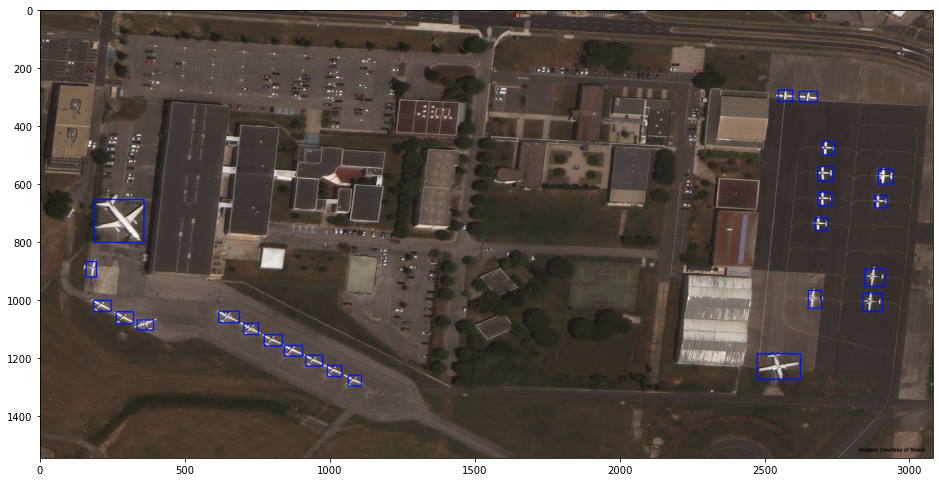

In [41]:
# Outputs will looks something like:
im_path = '/yoltv4/darknet/results/rareplanes_preds_v0/pred_plots/im0.jpg'
fig, ax = plt.subplots(figsize=(16,16))
_ = ax.imshow(skimage.io.imread(im_path))

_____
## 5. Score

Not fully implemented here just yet, but scoring can be accomplished with [Solaris](https://github.com/CosmiQ/solaris/tree/master/solaris/eval).  Within a Solaris docker file, execute the following on the command line:

    import solaris.eval

    gt_polygons_dir = path_to_ground_truth
    proposal_polygons_dir = os.path.join(yoltv4_path, 'darknet/results/rareplanes_preds_v0/geojsons_pix/')

    solaris.eval.vector.mAP_score(proposal_polygons_dir, gt_polygons_dir,
              prediction_cat_attrib="category", gt_cat_attrib='category',
              object_subset=[], threshold=0.5, confidence_attrib="prob",
              file_format="geojson")